In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.preprocessing import image, image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator



from tensorflow.keras.preprocessing import image_dataset_from_directory
import tensorflow_addons as tfa

In [2]:
TRAIN_DIR = '../../../data/cell_type/training'
TEST_DIR = '../../../data/cell_type/testing'
VAL_DIR = '../../../data/cell_type/validation'
# INPUT_WIDTH = 27
# INPUT_HEIGHT = 27

BATCH_SIZE = 64
IMG_SIZE = (32, 32)


train_dataset = image_dataset_from_directory(TRAIN_DIR,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             interpolation='bilinear',
                                             label_mode='categorical'
                                            )

validation_dataset = image_dataset_from_directory(VAL_DIR,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE,
                                                  interpolation='bilinear',
                                                  label_mode='categorical'
                                            )

test_dataset = image_dataset_from_directory(TEST_DIR,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE,
                                                  interpolation='bilinear',
                                                  label_mode='categorical'
                                            )

Found 7915 files belonging to 4 classes.
Found 990 files belonging to 4 classes.
Found 991 files belonging to 4 classes.


In [3]:
def get_class_name(class_num):
    if class_num == 0:
        return 'fibroblast'
    elif class_num == 1:
        return 'inflammatory'
    elif class_num == 2:
        return 'epithelial'
    else:
        return 'others'

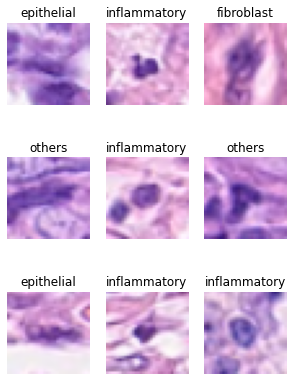

In [4]:
class_names = train_dataset.class_names

plt.figure(figsize=(5, 7))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(get_class_name(tf.where(tf.equal(labels[i], 1)).numpy()[0][0]))
        plt.axis("off")

In [5]:
train_dataset.class_names

['0', '1', '2', '3']

In [6]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [7]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

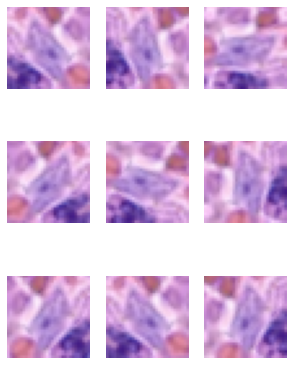

In [8]:
for image, _ in train_dataset.take(1):
    plt.figure(figsize=(5, 7))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0])
        plt.axis('off')

In [10]:
# Create the base model from the Resnet50V2 model without loading pretrained-weights
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.ResNet50V2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights=None)

In [11]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 38, 38, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 16, 16, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 18, 18, 64)   0           conv1_conv[0][0]                 
_________________________________________________________________________________________

In [12]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
# feature_batch_average = global_average_layer(feature_batch)
# print(feature_batch_average.shape)

In [13]:
prediction_layer = tf.keras.layers.Dense(4)
# prediction_batch = prediction_layer(feature_batch_average)
# print(prediction_batch.shape)

In [14]:
inputs = tf.keras.Input(shape=(32, 32, 3))
x = data_augmentation(inputs)
# x = preprocess_input(x)
x = base_model(x, training=True)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [15]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_score(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))



In [16]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy', f1_score ,precision_m, recall_m])

/home/trungngo/Desktop/venv/colon-cancer-classification/lib/python3.8/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [17]:
len(model.trainable_variables)

174

In [18]:
epochs = 500

loss0, accuracy0, f1_0, precision0, recall0 = model.evaluate(validation_dataset)

16/16 [==============================] - 3s 21ms/step - loss: 1.5927 - accuracy: 0.3273 - f1_score: 0.2731 - precision_m: 0.3311 - recall_m: 0.2327


In [19]:
import time
start_time = time.time()

In [20]:
history = model.fit(train_dataset,
                    epochs=epochs,
                    validation_data=validation_dataset,
#                     callbacks=[lr_reducer]
                   )

Epoch 1/500
124/124 [==============================] - 6s 25ms/step - loss: 1.1894 - accuracy: 0.5366 - f1_score: 0.5145 - precision_m: 0.5362 - recall_m: 0.4966 - val_loss: 1.0478 - val_accuracy: 0.5798 - val_f1_score: 0.5576 - val_precision_m: 0.5851 - val_recall_m: 0.5348
Epoch 2/500
124/124 [==============================] - 3s 21ms/step - loss: 1.0190 - accuracy: 0.6056 - f1_score: 0.5835 - precision_m: 0.5831 - recall_m: 0.5853 - val_loss: 0.9745 - val_accuracy: 0.6354 - val_f1_score: 0.6146 - val_precision_m: 0.5988 - val_recall_m: 0.6321
Epoch 3/500
124/124 [==============================] - 3s 21ms/step - loss: 0.9730 - accuracy: 0.6255 - f1_score: 0.6084 - precision_m: 0.5911 - recall_m: 0.6284 - val_loss: 0.8308 - val_accuracy: 0.6838 - val_f1_score: 0.6466 - val_precision_m: 0.6486 - val_recall_m: 0.6459
Epoch 4/500
124/124 [==============================] - 3s 21ms/step - loss: 0.8970 - accuracy: 0.6489 - f1_score: 0.6229 - precision_m: 0.6011 - recall_m: 0.6476 - val_loss

Epoch 31/500
124/124 [==============================] - 3s 21ms/step - loss: 0.5630 - accuracy: 0.7837 - f1_score: 0.7328 - precision_m: 0.6372 - recall_m: 0.8640 - val_loss: 0.5711 - val_accuracy: 0.7838 - val_f1_score: 0.7346 - val_precision_m: 0.6415 - val_recall_m: 0.8605
Epoch 32/500
124/124 [==============================] - 3s 21ms/step - loss: 0.5400 - accuracy: 0.7880 - f1_score: 0.7330 - precision_m: 0.6316 - recall_m: 0.8745 - val_loss: 0.6033 - val_accuracy: 0.7697 - val_f1_score: 0.7218 - val_precision_m: 0.6203 - val_recall_m: 0.8640
Epoch 33/500
124/124 [==============================] - 3s 21ms/step - loss: 0.5593 - accuracy: 0.7800 - f1_score: 0.7268 - precision_m: 0.6257 - recall_m: 0.8679 - val_loss: 0.5993 - val_accuracy: 0.7717 - val_f1_score: 0.7085 - val_precision_m: 0.5969 - val_recall_m: 0.8724
Epoch 34/500
124/124 [==============================] - 3s 21ms/step - loss: 0.5508 - accuracy: 0.7874 - f1_score: 0.7295 - precision_m: 0.6256 - recall_m: 0.8760 - val_

Epoch 61/500
124/124 [==============================] - 3s 22ms/step - loss: 0.4206 - accuracy: 0.8403 - f1_score: 0.7564 - precision_m: 0.6385 - recall_m: 0.9289 - val_loss: 0.5215 - val_accuracy: 0.8091 - val_f1_score: 0.7361 - val_precision_m: 0.6189 - val_recall_m: 0.9088
Epoch 62/500
124/124 [==============================] - 3s 21ms/step - loss: 0.4263 - accuracy: 0.8404 - f1_score: 0.7489 - precision_m: 0.6258 - recall_m: 0.9334 - val_loss: 0.5207 - val_accuracy: 0.8232 - val_f1_score: 0.7448 - val_precision_m: 0.6313 - val_recall_m: 0.9090
Epoch 63/500
124/124 [==============================] - 3s 22ms/step - loss: 0.4285 - accuracy: 0.8384 - f1_score: 0.7456 - precision_m: 0.6236 - recall_m: 0.9284 - val_loss: 0.5309 - val_accuracy: 0.8111 - val_f1_score: 0.7295 - val_precision_m: 0.6118 - val_recall_m: 0.9042
Epoch 64/500
124/124 [==============================] - 3s 21ms/step - loss: 0.4312 - accuracy: 0.8355 - f1_score: 0.7416 - precision_m: 0.6177 - recall_m: 0.9288 - val_

Epoch 91/500
124/124 [==============================] - 3s 22ms/step - loss: 0.3263 - accuracy: 0.8769 - f1_score: 0.7604 - precision_m: 0.6305 - recall_m: 0.9585 - val_loss: 0.5089 - val_accuracy: 0.8283 - val_f1_score: 0.7353 - val_precision_m: 0.6116 - val_recall_m: 0.9225
Epoch 92/500
124/124 [==============================] - 3s 22ms/step - loss: 0.3004 - accuracy: 0.8854 - f1_score: 0.7662 - precision_m: 0.6390 - recall_m: 0.9580 - val_loss: 0.5516 - val_accuracy: 0.8253 - val_f1_score: 0.7455 - val_precision_m: 0.6243 - val_recall_m: 0.9257
Epoch 93/500
124/124 [==============================] - 3s 21ms/step - loss: 0.2974 - accuracy: 0.8877 - f1_score: 0.7719 - precision_m: 0.6444 - recall_m: 0.9633 - val_loss: 0.5506 - val_accuracy: 0.8273 - val_f1_score: 0.7353 - val_precision_m: 0.6125 - val_recall_m: 0.9202
Epoch 94/500
124/124 [==============================] - 3s 21ms/step - loss: 0.3011 - accuracy: 0.8838 - f1_score: 0.7636 - precision_m: 0.6340 - recall_m: 0.9607 - val_

124/124 [==============================] - 3s 21ms/step - loss: 0.2046 - accuracy: 0.9265 - f1_score: 0.7746 - precision_m: 0.6393 - recall_m: 0.9836 - val_loss: 0.6411 - val_accuracy: 0.8253 - val_f1_score: 0.7351 - val_precision_m: 0.6127 - val_recall_m: 0.9189
Epoch 121/500
124/124 [==============================] - 3s 21ms/step - loss: 0.1977 - accuracy: 0.9244 - f1_score: 0.7884 - precision_m: 0.6576 - recall_m: 0.9853 - val_loss: 0.6881 - val_accuracy: 0.8152 - val_f1_score: 0.7493 - val_precision_m: 0.6328 - val_recall_m: 0.9195
Epoch 122/500
124/124 [==============================] - 3s 20ms/step - loss: 0.1960 - accuracy: 0.9260 - f1_score: 0.7881 - precision_m: 0.6575 - recall_m: 0.9844 - val_loss: 0.6526 - val_accuracy: 0.8182 - val_f1_score: 0.7404 - val_precision_m: 0.6160 - val_recall_m: 0.9293
Epoch 123/500
124/124 [==============================] - 3s 21ms/step - loss: 0.2084 - accuracy: 0.9250 - f1_score: 0.7801 - precision_m: 0.6471 - recall_m: 0.9833 - val_loss: 0.62

124/124 [==============================] - 3s 21ms/step - loss: 0.1339 - accuracy: 0.9525 - f1_score: 0.8078 - precision_m: 0.6818 - recall_m: 0.9924 - val_loss: 0.7573 - val_accuracy: 0.8242 - val_f1_score: 0.7373 - val_precision_m: 0.6171 - val_recall_m: 0.9169
Epoch 150/500
124/124 [==============================] - 3s 20ms/step - loss: 0.1399 - accuracy: 0.9514 - f1_score: 0.8088 - precision_m: 0.6837 - recall_m: 0.9912 - val_loss: 0.6776 - val_accuracy: 0.8202 - val_f1_score: 0.7346 - val_precision_m: 0.6087 - val_recall_m: 0.9265
Epoch 151/500
124/124 [==============================] - 3s 21ms/step - loss: 0.1340 - accuracy: 0.9506 - f1_score: 0.8060 - precision_m: 0.6796 - recall_m: 0.9912 - val_loss: 0.7582 - val_accuracy: 0.8283 - val_f1_score: 0.7480 - val_precision_m: 0.6281 - val_recall_m: 0.9258
Epoch 152/500
124/124 [==============================] - 3s 21ms/step - loss: 0.1387 - accuracy: 0.9502 - f1_score: 0.8046 - precision_m: 0.6770 - recall_m: 0.9924 - val_loss: 0.78

124/124 [==============================] - 3s 21ms/step - loss: 0.1035 - accuracy: 0.9622 - f1_score: 0.8197 - precision_m: 0.6996 - recall_m: 0.9909 - val_loss: 0.8375 - val_accuracy: 0.8061 - val_f1_score: 0.7358 - val_precision_m: 0.6131 - val_recall_m: 0.9205
Epoch 179/500
124/124 [==============================] - 3s 21ms/step - loss: 0.0955 - accuracy: 0.9651 - f1_score: 0.8214 - precision_m: 0.7007 - recall_m: 0.9935 - val_loss: 0.8099 - val_accuracy: 0.8263 - val_f1_score: 0.7426 - val_precision_m: 0.6221 - val_recall_m: 0.9217
Epoch 180/500
124/124 [==============================] - 3s 21ms/step - loss: 0.0971 - accuracy: 0.9635 - f1_score: 0.8234 - precision_m: 0.7033 - recall_m: 0.9942 - val_loss: 0.8272 - val_accuracy: 0.8222 - val_f1_score: 0.7565 - val_precision_m: 0.6393 - val_recall_m: 0.9266
Epoch 181/500
124/124 [==============================] - 3s 21ms/step - loss: 0.0960 - accuracy: 0.9656 - f1_score: 0.8259 - precision_m: 0.7067 - recall_m: 0.9946 - val_loss: 0.84

124/124 [==============================] - 3s 21ms/step - loss: 0.0696 - accuracy: 0.9771 - f1_score: 0.8326 - precision_m: 0.7151 - recall_m: 0.9972 - val_loss: 0.9137 - val_accuracy: 0.8172 - val_f1_score: 0.7537 - val_precision_m: 0.6394 - val_recall_m: 0.9187
Epoch 208/500
124/124 [==============================] - 3s 21ms/step - loss: 0.0712 - accuracy: 0.9740 - f1_score: 0.8408 - precision_m: 0.7272 - recall_m: 0.9976 - val_loss: 0.9172 - val_accuracy: 0.8111 - val_f1_score: 0.7593 - val_precision_m: 0.6499 - val_recall_m: 0.9148
Epoch 209/500
124/124 [==============================] - 3s 21ms/step - loss: 0.0775 - accuracy: 0.9725 - f1_score: 0.8331 - precision_m: 0.7166 - recall_m: 0.9958 - val_loss: 0.8544 - val_accuracy: 0.8111 - val_f1_score: 0.7492 - val_precision_m: 0.6307 - val_recall_m: 0.9233
Epoch 210/500
124/124 [==============================] - 3s 21ms/step - loss: 0.0922 - accuracy: 0.9682 - f1_score: 0.8341 - precision_m: 0.7188 - recall_m: 0.9948 - val_loss: 0.86

124/124 [==============================] - 3s 21ms/step - loss: 0.0656 - accuracy: 0.9764 - f1_score: 0.8511 - precision_m: 0.7424 - recall_m: 0.9982 - val_loss: 0.9109 - val_accuracy: 0.8091 - val_f1_score: 0.7510 - val_precision_m: 0.6375 - val_recall_m: 0.9146
Epoch 237/500
124/124 [==============================] - 3s 21ms/step - loss: 0.0686 - accuracy: 0.9762 - f1_score: 0.8528 - precision_m: 0.7461 - recall_m: 0.9960 - val_loss: 0.9699 - val_accuracy: 0.8202 - val_f1_score: 0.7475 - val_precision_m: 0.6325 - val_recall_m: 0.9145
Epoch 238/500
124/124 [==============================] - 3s 21ms/step - loss: 0.0625 - accuracy: 0.9770 - f1_score: 0.8493 - precision_m: 0.7396 - recall_m: 0.9984 - val_loss: 0.9303 - val_accuracy: 0.8162 - val_f1_score: 0.7500 - val_precision_m: 0.6346 - val_recall_m: 0.9177
Epoch 239/500
124/124 [==============================] - 3s 21ms/step - loss: 0.0626 - accuracy: 0.9793 - f1_score: 0.8445 - precision_m: 0.7332 - recall_m: 0.9966 - val_loss: 0.90

124/124 [==============================] - 3s 21ms/step - loss: 0.0544 - accuracy: 0.9810 - f1_score: 0.8593 - precision_m: 0.7551 - recall_m: 0.9977 - val_loss: 1.0019 - val_accuracy: 0.8192 - val_f1_score: 0.7563 - val_precision_m: 0.6461 - val_recall_m: 0.9126
Epoch 266/500
124/124 [==============================] - 3s 21ms/step - loss: 0.0454 - accuracy: 0.9847 - f1_score: 0.8643 - precision_m: 0.7630 - recall_m: 0.9975 - val_loss: 1.0475 - val_accuracy: 0.8263 - val_f1_score: 0.7669 - val_precision_m: 0.6614 - val_recall_m: 0.9137
Epoch 267/500
124/124 [==============================] - 3s 21ms/step - loss: 0.0588 - accuracy: 0.9807 - f1_score: 0.8640 - precision_m: 0.7630 - recall_m: 0.9971 - val_loss: 1.0146 - val_accuracy: 0.8152 - val_f1_score: 0.7533 - val_precision_m: 0.6479 - val_recall_m: 0.9008
Epoch 268/500
124/124 [==============================] - 3s 21ms/step - loss: 0.0566 - accuracy: 0.9793 - f1_score: 0.8594 - precision_m: 0.7561 - recall_m: 0.9962 - val_loss: 0.97

124/124 [==============================] - 3s 21ms/step - loss: 0.0492 - accuracy: 0.9821 - f1_score: 0.8695 - precision_m: 0.7713 - recall_m: 0.9975 - val_loss: 1.0004 - val_accuracy: 0.8141 - val_f1_score: 0.7630 - val_precision_m: 0.6560 - val_recall_m: 0.9127
Epoch 295/500
124/124 [==============================] - 3s 21ms/step - loss: 0.0544 - accuracy: 0.9808 - f1_score: 0.8620 - precision_m: 0.7598 - recall_m: 0.9971 - val_loss: 1.0286 - val_accuracy: 0.8152 - val_f1_score: 0.7532 - val_precision_m: 0.6425 - val_recall_m: 0.9112
Epoch 296/500
124/124 [==============================] - 3s 21ms/step - loss: 0.0536 - accuracy: 0.9813 - f1_score: 0.8596 - precision_m: 0.7557 - recall_m: 0.9975 - val_loss: 0.9943 - val_accuracy: 0.8162 - val_f1_score: 0.7445 - val_precision_m: 0.6348 - val_recall_m: 0.9006
Epoch 297/500
124/124 [==============================] - 3s 21ms/step - loss: 0.0591 - accuracy: 0.9799 - f1_score: 0.8542 - precision_m: 0.7484 - recall_m: 0.9957 - val_loss: 1.00

124/124 [==============================] - 3s 22ms/step - loss: 0.0425 - accuracy: 0.9856 - f1_score: 0.8720 - precision_m: 0.7756 - recall_m: 0.9968 - val_loss: 1.0372 - val_accuracy: 0.8253 - val_f1_score: 0.7677 - val_precision_m: 0.6615 - val_recall_m: 0.9155
Epoch 324/500
124/124 [==============================] - 3s 21ms/step - loss: 0.0456 - accuracy: 0.9841 - f1_score: 0.8769 - precision_m: 0.7829 - recall_m: 0.9974 - val_loss: 1.0558 - val_accuracy: 0.8152 - val_f1_score: 0.7748 - val_precision_m: 0.6729 - val_recall_m: 0.9141
Epoch 325/500
124/124 [==============================] - 3s 22ms/step - loss: 0.0441 - accuracy: 0.9871 - f1_score: 0.8730 - precision_m: 0.7770 - recall_m: 0.9971 - val_loss: 0.9092 - val_accuracy: 0.8323 - val_f1_score: 0.7658 - val_precision_m: 0.6562 - val_recall_m: 0.9204
Epoch 326/500
124/124 [==============================] - 3s 22ms/step - loss: 0.0307 - accuracy: 0.9891 - f1_score: 0.8758 - precision_m: 0.7805 - recall_m: 0.9989 - val_loss: 1.06

124/124 [==============================] - 3s 22ms/step - loss: 0.0389 - accuracy: 0.9858 - f1_score: 0.8862 - precision_m: 0.7976 - recall_m: 0.9977 - val_loss: 1.1048 - val_accuracy: 0.8192 - val_f1_score: 0.7700 - val_precision_m: 0.6707 - val_recall_m: 0.9046
Epoch 353/500
124/124 [==============================] - 3s 20ms/step - loss: 0.0415 - accuracy: 0.9861 - f1_score: 0.8784 - precision_m: 0.7848 - recall_m: 0.9984 - val_loss: 1.1104 - val_accuracy: 0.8212 - val_f1_score: 0.7648 - val_precision_m: 0.6610 - val_recall_m: 0.9079
Epoch 354/500
124/124 [==============================] - 3s 21ms/step - loss: 0.0384 - accuracy: 0.9867 - f1_score: 0.8838 - precision_m: 0.7935 - recall_m: 0.9982 - val_loss: 1.0472 - val_accuracy: 0.8192 - val_f1_score: 0.7690 - val_precision_m: 0.6683 - val_recall_m: 0.9068
Epoch 355/500
124/124 [==============================] - 3s 21ms/step - loss: 0.0402 - accuracy: 0.9858 - f1_score: 0.8851 - precision_m: 0.7959 - recall_m: 0.9979 - val_loss: 1.04

124/124 [==============================] - 3s 21ms/step - loss: 0.0364 - accuracy: 0.9855 - f1_score: 0.8991 - precision_m: 0.8185 - recall_m: 0.9981 - val_loss: 1.0409 - val_accuracy: 0.8222 - val_f1_score: 0.7860 - val_precision_m: 0.6914 - val_recall_m: 0.9117
Epoch 382/500
124/124 [==============================] - 3s 21ms/step - loss: 0.0365 - accuracy: 0.9874 - f1_score: 0.8981 - precision_m: 0.8182 - recall_m: 0.9963 - val_loss: 0.9918 - val_accuracy: 0.8273 - val_f1_score: 0.7811 - val_precision_m: 0.6841 - val_recall_m: 0.9110
Epoch 383/500
124/124 [==============================] - 3s 21ms/step - loss: 0.0301 - accuracy: 0.9907 - f1_score: 0.8961 - precision_m: 0.8131 - recall_m: 0.9987 - val_loss: 1.1061 - val_accuracy: 0.8152 - val_f1_score: 0.7790 - val_precision_m: 0.6827 - val_recall_m: 0.9081
Epoch 384/500
124/124 [==============================] - 3s 21ms/step - loss: 0.0326 - accuracy: 0.9886 - f1_score: 0.8971 - precision_m: 0.8151 - recall_m: 0.9982 - val_loss: 1.09

124/124 [==============================] - 3s 21ms/step - loss: 0.0258 - accuracy: 0.9901 - f1_score: 0.8993 - precision_m: 0.8187 - recall_m: 0.9984 - val_loss: 1.1567 - val_accuracy: 0.8121 - val_f1_score: 0.7757 - val_precision_m: 0.6805 - val_recall_m: 0.9029
Epoch 411/500
124/124 [==============================] - 3s 22ms/step - loss: 0.0386 - accuracy: 0.9875 - f1_score: 0.8976 - precision_m: 0.8169 - recall_m: 0.9966 - val_loss: 1.0281 - val_accuracy: 0.8273 - val_f1_score: 0.7837 - val_precision_m: 0.6927 - val_recall_m: 0.9031
Epoch 412/500
124/124 [==============================] - 3s 21ms/step - loss: 0.0305 - accuracy: 0.9914 - f1_score: 0.9025 - precision_m: 0.8239 - recall_m: 0.9985 - val_loss: 1.1072 - val_accuracy: 0.8283 - val_f1_score: 0.7867 - val_precision_m: 0.6981 - val_recall_m: 0.9021
Epoch 413/500
124/124 [==============================] - 3s 21ms/step - loss: 0.0307 - accuracy: 0.9912 - f1_score: 0.9033 - precision_m: 0.8262 - recall_m: 0.9973 - val_loss: 1.12

124/124 [==============================] - 3s 21ms/step - loss: 0.0273 - accuracy: 0.9904 - f1_score: 0.9049 - precision_m: 0.8282 - recall_m: 0.9984 - val_loss: 1.1151 - val_accuracy: 0.8212 - val_f1_score: 0.7802 - val_precision_m: 0.6876 - val_recall_m: 0.9027
Epoch 440/500
124/124 [==============================] - 3s 20ms/step - loss: 0.0231 - accuracy: 0.9924 - f1_score: 0.9153 - precision_m: 0.8451 - recall_m: 0.9990 - val_loss: 1.1122 - val_accuracy: 0.8323 - val_f1_score: 0.7878 - val_precision_m: 0.6969 - val_recall_m: 0.9070
Epoch 441/500
124/124 [==============================] - 3s 21ms/step - loss: 0.0225 - accuracy: 0.9912 - f1_score: 0.9142 - precision_m: 0.8431 - recall_m: 0.9995 - val_loss: 1.0896 - val_accuracy: 0.8141 - val_f1_score: 0.7727 - val_precision_m: 0.6746 - val_recall_m: 0.9049
Epoch 442/500
124/124 [==============================] - 3s 21ms/step - loss: 0.0345 - accuracy: 0.9874 - f1_score: 0.9049 - precision_m: 0.8286 - recall_m: 0.9977 - val_loss: 1.04

124/124 [==============================] - 3s 21ms/step - loss: 0.0416 - accuracy: 0.9865 - f1_score: 0.9103 - precision_m: 0.8382 - recall_m: 0.9968 - val_loss: 1.0577 - val_accuracy: 0.8303 - val_f1_score: 0.7895 - val_precision_m: 0.6992 - val_recall_m: 0.9071
Epoch 469/500
124/124 [==============================] - 3s 22ms/step - loss: 0.0341 - accuracy: 0.9876 - f1_score: 0.9112 - precision_m: 0.8393 - recall_m: 0.9974 - val_loss: 1.1140 - val_accuracy: 0.8162 - val_f1_score: 0.7749 - val_precision_m: 0.6802 - val_recall_m: 0.9010
Epoch 470/500
124/124 [==============================] - 3s 20ms/step - loss: 0.0263 - accuracy: 0.9905 - f1_score: 0.9150 - precision_m: 0.8457 - recall_m: 0.9975 - val_loss: 1.1573 - val_accuracy: 0.8273 - val_f1_score: 0.7845 - val_precision_m: 0.6972 - val_recall_m: 0.8979
Epoch 471/500
124/124 [==============================] - 3s 21ms/step - loss: 0.0218 - accuracy: 0.9931 - f1_score: 0.9155 - precision_m: 0.8461 - recall_m: 0.9984 - val_loss: 1.15

124/124 [==============================] - 3s 20ms/step - loss: 0.0322 - accuracy: 0.9885 - f1_score: 0.9160 - precision_m: 0.8472 - recall_m: 0.9978 - val_loss: 1.0943 - val_accuracy: 0.8152 - val_f1_score: 0.7803 - val_precision_m: 0.6923 - val_recall_m: 0.8949
Epoch 498/500
124/124 [==============================] - 3s 21ms/step - loss: 0.0216 - accuracy: 0.9919 - f1_score: 0.9139 - precision_m: 0.8431 - recall_m: 0.9986 - val_loss: 1.1315 - val_accuracy: 0.8232 - val_f1_score: 0.7825 - val_precision_m: 0.6914 - val_recall_m: 0.9020
Epoch 499/500
124/124 [==============================] - 3s 21ms/step - loss: 0.0185 - accuracy: 0.9933 - f1_score: 0.9196 - precision_m: 0.8524 - recall_m: 0.9991 - val_loss: 1.2093 - val_accuracy: 0.8192 - val_f1_score: 0.7750 - val_precision_m: 0.6867 - val_recall_m: 0.8902
Epoch 500/500
124/124 [==============================] - 3s 21ms/step - loss: 0.0256 - accuracy: 0.9907 - f1_score: 0.9174 - precision_m: 0.8491 - recall_m: 0.9985 - val_loss: 1.23

In [21]:
print("---  Training time in seconds ---%s " % (time.time() - start_time))

---  Training time in seconds ---1324.7939991950989 


In [22]:
loss, accuracy, f1_score, precision, recall = model.evaluate(test_dataset)

16/16 [==============================] - 0s 21ms/step - loss: 1.1682 - accuracy: 0.8123 - f1_score: 0.7786 - precision_m: 0.6889 - recall_m: 0.8964


In [23]:
model.save('Resnet50V2-before-using-extraData.hdf5')

/home/trungngo/Desktop/venv/colon-cancer-classification/lib/python3.8/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


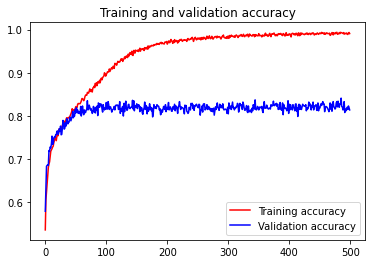

<Figure size 432x288 with 0 Axes>

In [24]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

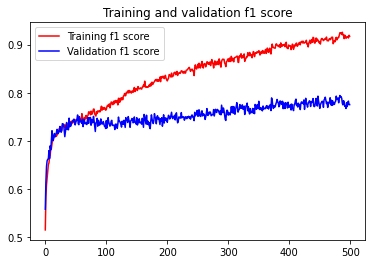

<Figure size 432x288 with 0 Axes>

In [25]:
import matplotlib.pyplot as plt
f1 = history.history['f1_score']
val_f1 = history.history['val_f1_score']

epochs = range(len(f1))

plt.plot(epochs, f1, 'r', label='Training f1 score')
plt.plot(epochs, val_f1, 'b', label='Validation f1 score')
plt.title('Training and validation f1 score')
plt.legend(loc=0)
plt.figure()


plt.show()

In [31]:
# print('Test loss:', loss)
print('Test accuracy:', accuracy)
print('Test F1 score', f1_score)

Test accuracy: 0.8123108148574829
Test F1 score 0.7786225080490112


In [27]:
print('Max validation accuracy:', max(history.history['val_accuracy']))

Max validation accuracy: 0.8414141535758972


In [28]:
print('Max training accuracy:', max(history.history['accuracy']))

Max training accuracy: 0.9938092231750488


In [29]:
print('Max validation F1 score:', max(history.history['val_f1_score']))

Max validation F1 score: 0.7942501306533813


In [30]:
print('Max training F1 score:', max(history.history['f1_score']))

Max training F1 score: 0.9258351922035217
